In [12]:
import numpy as np
import pyvista as pv
from pyvista import examples
from icosphere import icosphere
from scipy.sparse import csc_array, csc_matrix, identity
from scipy.sparse.linalg import spsolve 
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import pymeshfix as mf
from mpl_toolkits.mplot3d import Axes3D


from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d

WARNING- 1113 isolated vertices have been removed.


INFO- Loaded 35947 vertices and 69451 faces.
Patching holes...
Patched 5 holes
Fixing degeneracies and intersections

100% done 
INFO- ********* ITERATION 0 *********
INFO- Removing degeneracies...
INFO- Removing self-intersections...

99 % done   
INFO- No intersections detected.


/Users/ahmedahmed/anaconda3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


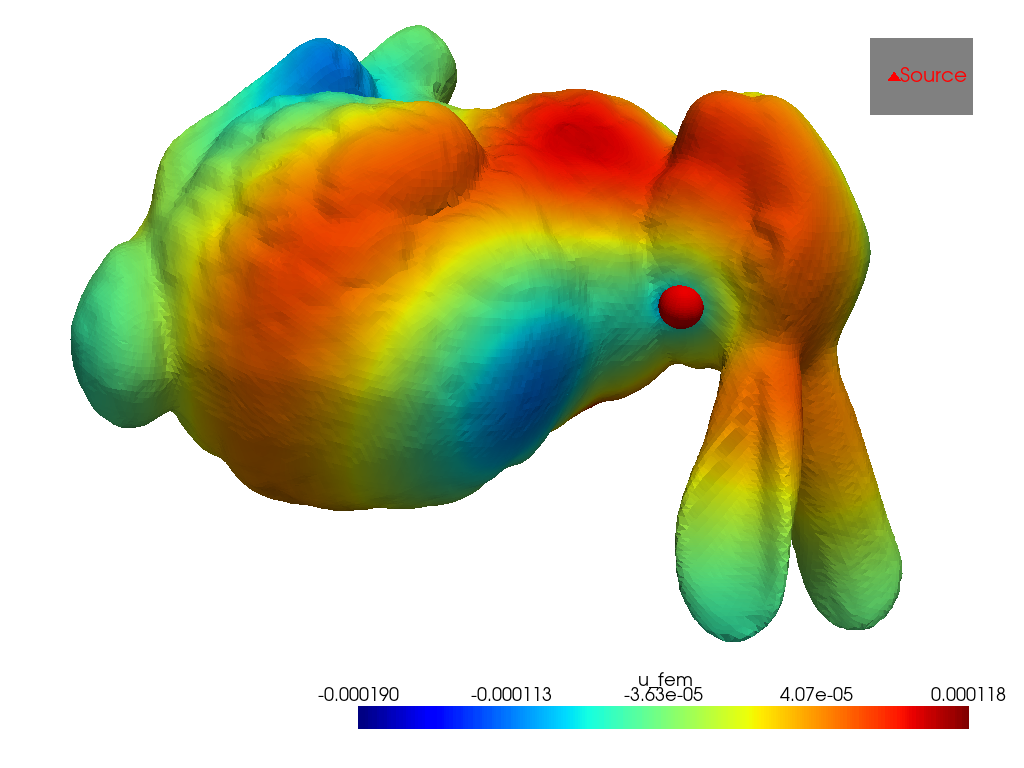

: 

In [18]:
def cartestian2Spherical(xyz):
    rthph = np.zeros(xyz.shape)
    r = np.sqrt(xyz[:,0]**2 + xyz[:,1]**2 + xyz[:,2]**2)
    rthph[:,0] = r#Radius
    rthph[:,1] = np.arctan2(xyz[:,1], xyz[:,0])#Azimuth angle 
    rthph[:,2] = np.arccos(xyz[:,2]/r)#Elevation angle defined downward from +z-axis
    return rthph

def generateLocalSMN(vert_arr, tri_arr, k, omega):
    k_arr = tri_arr[k,:]
    r1 = vert_arr[k_arr[0],:]
    r2 = vert_arr[k_arr[1],:]
    r3 = vert_arr[k_arr[2],:]
    #Get edges
    E1 = r2 - r3
    E2 = r3 - r1
    E3 = r1 - r2
    A = 0.5*np.linalg.norm(np.cross(E1,E2))
    Sk = np.zeros((3,3), dtype=np.double)
    Mk = np.zeros((3,3), dtype=np.double)
    if A > 0:
        Sk = (1.0/(4.0*A))*np.array([[np.dot(E1,E1),np.dot(E1,E2), np.dot(E1,E3)],
                                     [np.dot(E2,E1),np.dot(E2,E2), np.dot(E2,E3)],
                                     [np.dot(E3,E1),np.dot(E3,E2), np.dot(E3,E3)]], dtype=np.double)
        Mk = (A/12.0)*np.array([[2,1,1],[1,2,1],[1,1,2]], dtype=np.double)
        Nk = (omega**2)*(A/12.0)*np.array([[2,1,1],[1,2,1],[1,1,2]], dtype=np.double)
    return k_arr, (-1.0*Sk), Mk, Nk

def generateSMSparse(vert_arr, tri_arr, omega):
    N_v = vert_arr.shape[0]
    V_S = []
    V_M = []
    I = []
    J = []
    for k in np.arange(tri_arr.shape[0]): 
        k_arr, Sk, Mk, Nk = generateLocalSMN(vert_arr, tri_arr, k, omega)
        for i in np.arange(3):
            for j in np.arange(3):
                V_S.append(Sk[i][j] + Nk[i][j])
                I.append(int(k_arr[i]))
                J.append(int(k_arr[j]))
                V_M.append(Mk[i][j])

    S = csc_matrix((np.array(V_S, dtype=np.double), (np.array(I, dtype=int),np.array(J, dtype=int))), shape=(N_v, N_v), dtype=np.double)
    M = csc_matrix((np.array(V_M, dtype=np.double), (np.array(I, dtype=int),np.array(J, dtype=int))), shape=(N_v, N_v), dtype=np.double)
    return S,M


def plotSolution(V, faces, u_fem, source_idx):
    # Create a PyVista mesh object
    mesh = pv.PolyData(V, faces)
    mesh['u_fem'] = u_fem  # Add your data to the mesh

    # Create plotting object and add the mesh
    plotter = pv.Plotter()
    plotter.add_mesh(mesh, scalars='u_fem', cmap='jet', show_edges=False)

    # Highlight the source location with a larger, red sphere
    source_sphere = pv.Sphere(radius=0.05, center=V[source_idx])
    plotter.add_mesh(source_sphere, color='red')

    # Adjust camera position and zoom
    plotter.view_isometric()
    plotter.camera.zoom(1.5)

    # Show the plotter
    # Add the legend with specified font size
    plotter.add_legend(labels=[('Source', 'red')], size=(0.1, 0.1))
    plotter.show()


def solveBunny(omega):
    mesh_bun_holes = examples.download_bunny().triangulate()
    mesh_bun = mf.MeshFix(mesh_bun_holes)
    mesh_bun.repair(verbose=True)
    meshb = mesh_bun.mesh
    V = 10.0 * meshb.points
    T = meshb.faces.reshape((-1, 4))[:, 1:]
    # PyVista requires faces to start with the number of points in each face
    faces = np.hstack((np.full((T.shape[0], 1), 3, dtype=T.dtype), T)).ravel()
    S, M = generateSMSparse(V, T, omega)
    f = np.zeros(V.shape[0])
    diracDeltaIdx = 400  # Replace with the correct index for the head
    f[diracDeltaIdx] = 2.0
    epsilon = 1.0e-8
    A = S + (epsilon*identity(V.shape[0], dtype=np.double, format="csc"))
    b = M.dot(f)
    u = spsolve(A, b)
    plotSolution(V, faces, u, diracDeltaIdx)

def main():
    omega = 2.0*np.pi
    solveBunny(omega)

if __name__ == "__main__":
    main()